In [142]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from shapely import wkt, Polygon
from pathlib import Path
import h3
import os
import math
from requests import HTTPError

In [153]:
base_dir = Path("/Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture")
img_dir = base_dir / "img"
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
modes = ["walk", "bike", "drive"]
acts_om = [
    "health_and_medical",
    "eat_and_drink",
    "retail",
    "arts_and_entertainment",
    "public_service_and_government",
    "jobs"
]
acts_mep = [
    "healthcare",
    "food",
    "retail",
    "entertainment",
    "services",
    "jobs",
]
variants = [
    ("res4", 4, "/Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/mep_matrix_res4.csv", acts_mep),
    ("res5", 5, "/Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/mep_matrix_res5.csv", acts_mep),
    ("res6", 6, "/Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/mep_matrix_res6.csv.gz", acts_om),
    ("res7", 7, "/Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/mep_matrix_res7.csv.gz", acts_om)
]
providers = [ctx.providers.USGS.USImagery, ctx.providers.USGS.USTopo]
continental_bbox = wkt.loads("POLYGON ((-130.628818 20.468189, -61.032502 20.468189, -61.032502 50.958427, -130.628818 50.958427, -130.628818 20.468189))")

In [225]:
from typing import Dict, List, Optional, Tuple

from shapely import Geometry


def hex_to_poly(hex_id: str) -> Polygon:
    coords = h3.cell_to_boundary(hex_id)
    polygon = Polygon([(t[1], t[0]) for t in coords])
    return polygon

def to_log10(df, col: str):
    df[col] = df[col].apply(lambda x: int(math.log10(x) if x >= 1.0 else 0))

def plot_mep_map(df,
         column: str,
         title: str,
         out_file: str,
         provider):
    fig, ax = plt.subplots()
    df.plot(column, ax=ax, alpha=.5, cmap='summer', edgecolor="k", linewidth=0.00001, legend=True)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ctx.add_basemap(ax=ax, source=provider)
    fig.savefig(out_file, dpi=600, bbox_inches="tight")
    plt.close()


def plot_mep_maps_and_summarize(variant: str, filepath: str, extents: List[Tuple[str, Geometry]], acts: List[str], log10: bool, plot: bool=True) -> List[Dict]:
    scores = []
    
    print(f"reading {filepath}")
    src_df = pd.read_csv(filepath)
    
    print(f"reading geometries from hex ids")
    src_df['geometry'] = src_df.hex_id.apply(hex_to_poly)
    
    print(f"creating plots for {len(extents)} extent(s)")
    for extent_name, extent in extents:
        # prep output
        out_dir = img_dir / extent_name / variant
        print(f"writing plots to {out_dir}")
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        
        print(f"filtering extent to '{extent_name}'")
        df = src_df[src_df.geometry.apply(lambda g: extent.contains(g))].copy()
        
        # ~~ OVERALL ~~
        # create subset dataframe and record score
        overall_df = df.groupby("hex_id").agg({"mep": "sum", "population": "first", "geometry": "first"}).fillna(0.0)
        mep_w = np.average(overall_df['mep'], weights=overall_df['population'])
        scores.append({"variant": variant, "extent_name": extent_name, "mep_overall": mep_w})

        # plot overall
        overall_fn = "mep_overall.png" if not log10 else "mep_overall_log10.png"
        overall_file = out_dir / overall_fn
        if not plot or overall_file.exists():
                print(f"skipping {overall_file}")
        else:
            print(f"plotting mep overall map for {variant}, {extent_name}")
            if log10:
                to_log10(overall_df, 'mep')
            overall_df = gpd.GeoDataFrame(overall_df, crs="EPSG:4326").to_crs("EPSG:3857")
            plot_mep_map(overall_df, "mep", "", overall_file, ctx.providers.USGS.USImagery)
        
        # ~~ POPULATION ~~
        # create subset dataframe and record score
        pop_df = df.groupby("hex_id").agg({"population": "first", "geometry": "first"}).fillna(0.0)
        pop_size = pop_df.population.sum()
        scores.append({"variant": variant, "extent_name": extent_name, "population": pop_size})

        # plot population
        pop_fn = "population.png" if not log10 else "population_log10.png"
        pop_file = out_dir / pop_fn
        if not plot or pop_file.exists():
                print(f"skipping {pop_file}")
        else:
            print(f"plotting population map for {variant}, {extent_name}")
            if log10:
                to_log10(pop_df, 'population')
            pop_df = gpd.GeoDataFrame(pop_df, crs="EPSG:4326").to_crs("EPSG:3857")
            plot_mep_map(pop_df, "population", "", pop_file, ctx.providers.USGS.USImagery)
            

        # ~~ MODE ~~
        for mode in modes:
            # create subset dataframe and record score
            mode_df = df[df["mode"]==mode].copy().fillna(0.0)
            mep_w = np.average(mode_df["mep"], weights=mode_df['population'])
            scores.append({"variant": variant, "extent_name": extent_name, f"mep_{mode}": mep_w})

            # plot mode
            mode_fn = f"mep_{mode}.png" if not log10 else f"mep_{mode}_log10.png"
            mode_file = out_dir / mode_fn
            if not plot or mode_file.exists():
                print(f"skipping {mode_file}")
            else:
                print(f"plotting mep {mode} map for {variant}, {extent_name}")
                if log10:
                    to_log10(mode_df, "mep")
                mode_df = gpd.GeoDataFrame(mode_df, crs="EPSG:4326").to_crs("EPSG:3857")
                try:
                    plot_mep_map(mode_df, f"mep", "", mode_file, ctx.providers.USGS.USImagery)
                except HTTPError as e:
                    print(f"mode_df has {len(mode_df)} rows, total bounds of {mode_df.total_bounds}")
                    raise e
        
        # ~~~ ACTIVITY ~~~
        for act_col, act_name in zip(acts, acts_mep):
            
            # create subset dataframe and record score
            col = f'mep_{act_col}'
            act_df = df.copy().fillna(0.0)
            mep_w = np.average(act_df[col], weights=act_df['population'])
            scores.append({"variant": variant, "extent_name": extent_name, f"mep_{act_col}": mep_w})

            act_fn = f"mep_{act_name}.png" if not log10 else f"mep_{act_name}_log10.png"
            act_file = out_dir / act_fn
            if not plot or act_file.exists():
                print(f"skipping {act_file}")
            else:
                print(f"plotting mep {act_col} map for {variant}")
                if log10:
                    to_log10(act_df, col)
                act_df = gpd.GeoDataFrame(act_df, crs="EPSG:4326").to_crs("EPSG:3857")
                plot_mep_map(act_df, col, "", act_file, ctx.providers.USGS.USImagery)
                
    return scores

In [155]:
nets_states = set(["MA", "NH", "VT", "ME", "RI", "CT", "NY", "PA", "NJ"])
ne_states = set(["MA", "NH", "VT", "ME", "RI", "CT"])
la_counties = set([
    "Ventura",
    "San Bernardino",
    "Riverside",
    "Los Angeles",
    "Orange"
])
counties = gpd.read_file("/Users/rfitzger/data/census/cb_2018_us_county_500k.zip")
states = gpd.read_file("/Users/rfitzger/data/census/cb_2018_us_state_500k.zip")

# New England + Tri-State Area
nets_extent = states[states['STUSPS'].isin(nets_states)].union_all()

# New England
ne_extent = states[states['STUSPS'].isin(ne_states)].union_all()

# Greater Los Angeles
la_extent = counties[(counties['NAME'].isin(la_counties))&(counties['STATEFP']=='06')].union_all()

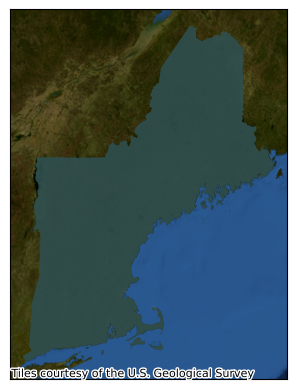

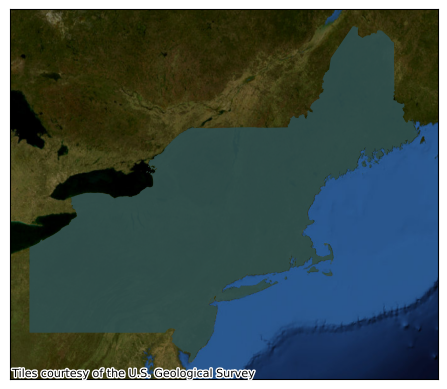

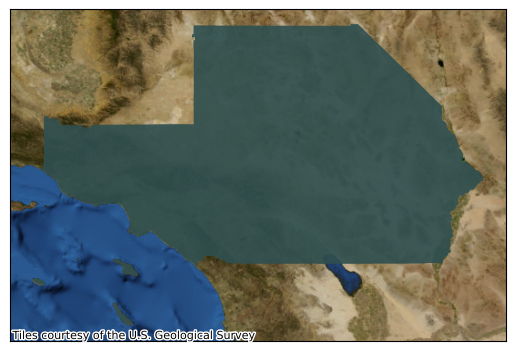

In [220]:
for extent in [ne_extent, nets_extent, la_extent]:
    fig, ax = plt.subplots()
    gpd.GeoDataFrame({"geometry": [extent]}, crs="EPSG:4326").to_crs("EPSG:3857").plot(ax=ax, alpha=0.9, color="darkslategrey")
    ax.set_xticks([])
    ax.set_yticks([])
    ctx.add_basemap(ax=ax, source=ctx.providers.USGS.USImagery)

In [229]:
extents = [
    ("continental", continental_bbox),
    ("nets", nets_extent),
    ("ne", ne_extent),
    ("la", la_extent)
]
summaries = []

for variant, res, filepath, acts in variants:
    summary = plot_mep_maps_and_summarize(variant, filepath, extents, acts, log10=False, plot=False)
    summaries.append(summary)

reading /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/mep_matrix_res4.csv
reading geometries from hex ids
creating plots for 4 extent(s)
writing plots to /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4
filtering extent to 'continental'
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4/mep_overall.png
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4/population.png
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4/mep_walk.png
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4/mep_bike.png
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4/mep_drive.png
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/img/continental/res4/mep_healthcare.png
skipping /Users/rfitzger/data/mep/mep3/output/2025-03-12-natl-overture/

In [230]:
summary = pd.DataFrame([s for subset in summaries for s in subset]).fillna(0.0).groupby(['variant', 'extent_name']).agg("sum")
summary.to_csv(base_dir / "summary.csv")

In [231]:
# manually fixed column names + moved data directly in file..
summary = pd.read_csv(base_dir / "summary.csv")
summary

,variant,extent_name,mep_overall,population,mep_walk,mep_bike,mep_drive,mep_healthcare,mep_food,mep_retail,mep_entertainment,mep_services,mep_jobs
0,res4,continental,6.908158,3.003190e+08,0.043055,0.323024,6.542079,0.141654,0.333146,0.590281,0.085190,0.401408,0.751040
1,res4,la,13.244631,1.022853e+07,0.000564,0.033931,13.210136,0.284280,0.568313,0.830297,0.152113,1.180153,1.399721
2,res4,ne,6.471651,5.861879e+06,0.023382,0.192060,6.256209,0.080376,0.207220,0.919443,0.050322,0.285306,0.614550
3,res4,nets,6.422675,2.748002e+07,0.010739,0.147112,6.264824,0.112445,0.246431,0.739018,0.062644,0.333565,0.646788
4,res5,continental,8.782255,3.191950e+08,0.080759,0.697473,8.004023,0.185011,0.406472,0.716886,0.105111,0.570279,0.943660
5,res5,la,19.067935,1.541245e+07,0.231745,1.593229,17.242961,0.424959,0.782755,1.110568,0.196105,1.887290,1.954301
6,res5,ne,7.974916,9.724626e+06,0.022097,0.161069,7.791750,0.117214,0.276281,1.087388,0.067735,0.335581,0.774106
7,res5,nets,12.377169,4.236006e+07,0.091716,1.177519,11.107934,0.283286,0.471943,1.165556,0.127844,0.817604,1.259490
8,res6,continental,9.516820,3.243636e+08,0.115230,0.915649,8.485942,0.205542,0.436189,0.769215,0.112007,0.632279,1.017041
9,res6,la,20.563700,1.722259e+07,0.181529,1.513638,18.868533,0.468653,0.859676,1.159854,0.216515,2.027793,2.122075


In [232]:
import seaborn as sns

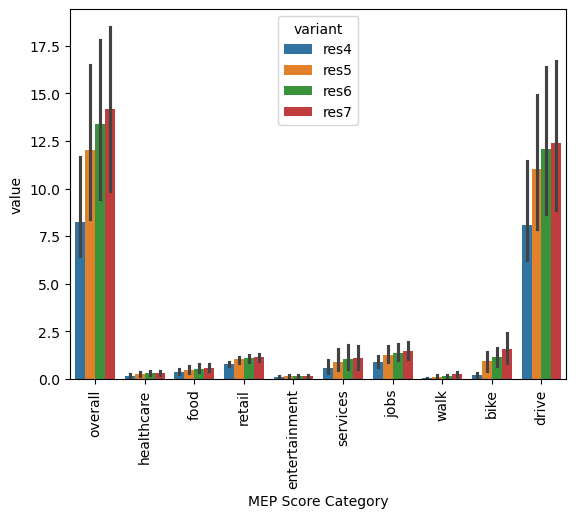

In [233]:
cols = ['mep_overall']
for act in acts_mep:
    cols.append(f'mep_{act}')
for mode in modes:
    cols.append(f'mep_{mode}')
long_fmt = summary.melt(id_vars=['extent_name', 'variant'], value_vars=cols)
long_fmt['variable'] = long_fmt['variable'].apply(lambda s: s.replace('mep_', ''))
ax = sns.barplot(long_fmt, x='variable', y='value', hue='variant')
ax.set_xlabel('MEP Score Category')
ax.tick_params('x', labelrotation=90)

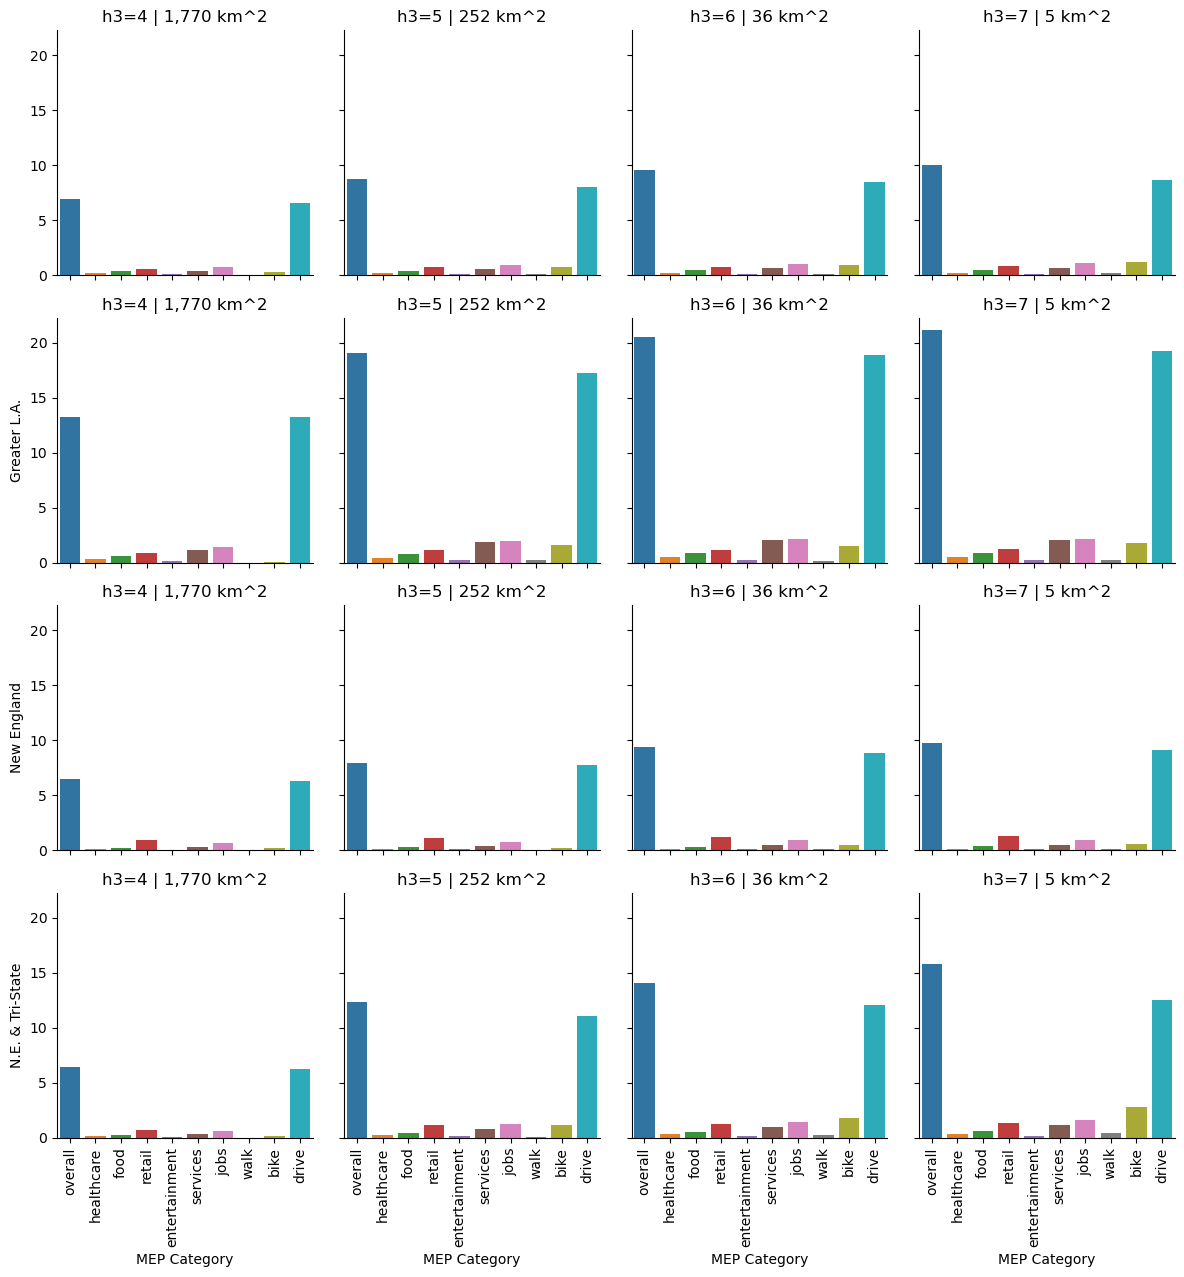

In [234]:
fg = sns.FacetGrid(long_fmt, row='extent_name', col='variant', hue='variable')
fg.map_dataframe(sns.barplot, x='variable', y='value')
for ax in fg.axes.flat:
    ax.tick_params('x', labelrotation=90)
    ax.set_xlabel('MEP Category')
    ax.set_ylabel("MEP Score")

def unpack_row(row_val):
    extents = {
        "la": "Greater L.A.",
        "ne": "New England",
        "nets": "N.E. & Tri-State"
    }
    ext_str = extents.get(row_val.strip())
    return ext_str
def unpack_col(col_val):
    resolutions = {
        "res4": "h3=4 | 1,770 km^2",
        "res5": "h3=5 | 252 km^2",
        "res6": "h3=6 | 36 km^2",
        "res7": "h3=7 | 5 km^2"
    }
    res_str = resolutions.get(col_val.strip())
    return res_str

fg.set_titles(col_template="{col_name}", row_template="{row_name}")
for (row_val, col_val), ax in fg.axes_dict.items():
    ax.set_title(unpack_col(col_val))
    ax.set_ylabel(unpack_row(row_val))

<Axes: xlabel='extent_name', ylabel='mep_overall'>

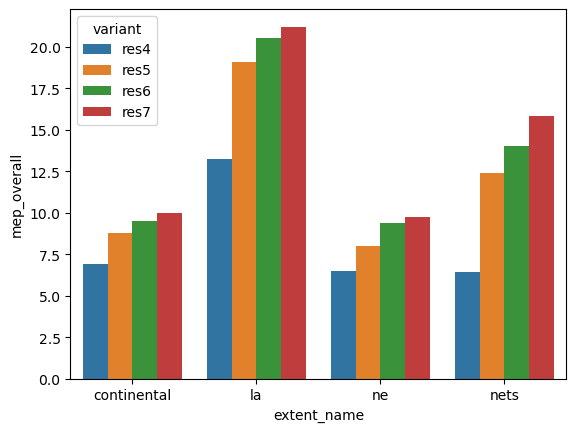

In [235]:
sns.barplot(summary, x='extent_name', y='mep_overall', hue='variant')